# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [21]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [41]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [40]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [39]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(num_features, n_hidden_1)
    # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)
    # Вихідний шар
    self.out_layer = DenseLayer(n_hidden_2, num_classes)


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer1(x, activation=1)
    x = self.layer2(x, activation=1)
    x = self.out_layer(x, activation=0)

    return x

In [38]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [36]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Обчислимо значення градієнта
    gradients = g.gradient(loss, neural_net.trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, neural_net.trainable_variables))

    return loss

In [27]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    loss = train(neural_net, batch_x, batch_y)
    loss_history.append(loss)
    if step % display_step == 0:
        pred = neural_net(batch_x)
        acc = accuracy(pred, batch_y)
        accuracy_history.append(acc)
        print(f"Step {step}, Minibatch Loss: {loss}, Accuracy: {acc}")

Step 100, Minibatch Loss: 83.50003051757812, Accuracy: 0.140625
Step 200, Minibatch Loss: 50.33723449707031, Accuracy: 0.109375
Step 300, Minibatch Loss: 34.87971496582031, Accuracy: 0.1640625
Step 400, Minibatch Loss: 26.80306625366211, Accuracy: 0.125
Step 500, Minibatch Loss: 21.476383209228516, Accuracy: 0.13671875
Step 600, Minibatch Loss: 17.710899353027344, Accuracy: 0.1796875
Step 700, Minibatch Loss: 15.10761833190918, Accuracy: 0.18359375
Step 800, Minibatch Loss: 13.298477172851562, Accuracy: 0.1640625
Step 900, Minibatch Loss: 11.662240982055664, Accuracy: 0.1875
Step 1000, Minibatch Loss: 10.59638786315918, Accuracy: 0.16015625
Step 1100, Minibatch Loss: 9.553494453430176, Accuracy: 0.12890625
Step 1200, Minibatch Loss: 8.78908920288086, Accuracy: 0.125
Step 1300, Minibatch Loss: 7.978105545043945, Accuracy: 0.22265625
Step 1400, Minibatch Loss: 7.514200687408447, Accuracy: 0.14453125
Step 1500, Minibatch Loss: 6.9787211418151855, Accuracy: 0.125
Step 1600, Minibatch Loss:

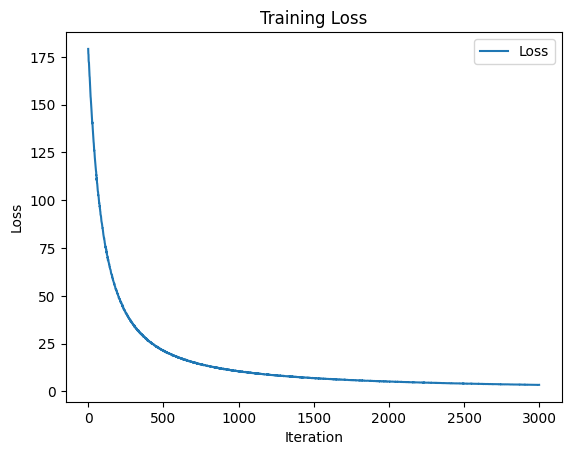

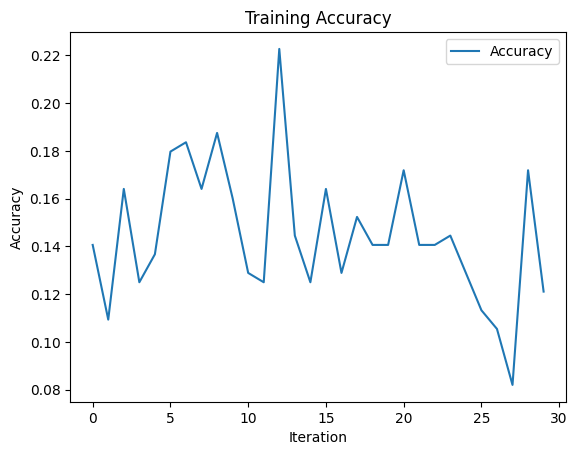

In [35]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

plt.plot(loss_history, label='Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

plt.plot(accuracy_history, label='Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

In [34]:
# Обчисліть точність навченої нейромережі
# Тестування моделі на тестових даних
def test_accuracy(neural_net, test_data):
    total_correct = 0
    total_images = 0
    for batch_x, batch_y in test_data:
        pred = neural_net(batch_x)
        total_correct += tf.reduce_sum(tf.cast(tf.argmax(pred, axis=1) == batch_y, tf.int32))
        total_images += batch_x.shape[0]
    accuracy = total_correct / total_images
    return accuracy.numpy()

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test.astype(np.int64))).batch(batch_size)
test_acc = test_accuracy(neural_net, test_data)
print(f"Test Accuracy: {test_acc}")

Test Accuracy: 0.1504


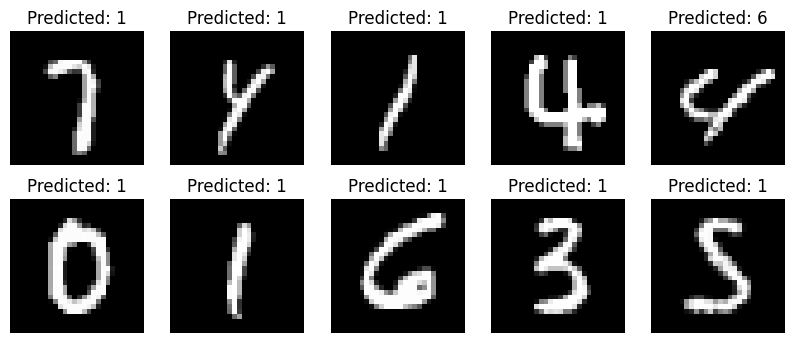

In [33]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

def predict_images(neural_net, test_data, num_images=10):
    plt.figure(figsize=(10, 4))
    for i, (batch_x, batch_y) in enumerate(test_data.take(num_images), 1):
        pred = neural_net(batch_x)
        for j in range(batch_x.shape[0]):
            plt.subplot(2, 5, i)
            plt.imshow(tf.reshape(batch_x[j], [28, 28]), cmap='gray')
            plt.title(f"Predicted: {tf.argmax(pred[j])}")
            plt.axis('off')
    plt.show()

predict_images(neural_net, test_data)